In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [203]:
def construct_norm_matrix(minX, maxX, minY, maxY, n):
    # create one-dimensional arrays for x and y
    x = np.linspace(minX, maxX, n)
    y = np.linspace(minY, maxY, n)
    # create the mesh based on these arrays
    X, Y = np.meshgrid(x, y)
    X = X.reshape((np.prod(X.shape),1))
    Y = Y.reshape((np.prod(Y.shape),1))
    X_matrix = (np.repeat(X, n**2, axis = 0)).reshape((n**2, n**2))
    Y_matrix = (np.repeat(Y, n**2, axis = 0)).reshape((n**2, n**2))
    longitude_squared = np.square(np.subtract(X_matrix, np.transpose(X_matrix)))
    latitude_squared = np.square(np.subtract(Y_matrix, np.transpose(Y_matrix)))
    norm_matrix = np.sqrt(np.add(longitude_squared, latitude_squared))
    return norm_matrix

#mask needs to be type numpy of 0s/1s, returns norm matrix with rows and columns associated with
#masked locations in original nxn matrix masked out in n**2xn**2 matrix (now (n**2-m)x(n**2-m))
def construct_masked_norm_matrix(mask, minX, maxX, minY, maxY, n):
    # create one-dimensional arrays for x and y
    x = np.linspace(minX, maxX, n)
    y = np.linspace(minY, maxY, n)
    # create the mesh based on these arrays
    X, Y = np.meshgrid(x, y)
    #X is a matrix of nxn which is latitudes of all nxn obs, same for Y
    X = X.reshape((np.prod(X.shape),1))
    Y = Y.reshape((np.prod(Y.shape),1))
    missing_indices = (np.argwhere(mask.reshape((n**2))))
    m = missing_indices.shape[0]
    missing_indices = missing_indices.reshape((m))
    X = np.delete(X, missing_indices, axis = 0)
    Y = np.delete(Y, missing_indices, axis = 0)
    #reshape X and Y to (n**2-mx1) vectors of latitude and longitude respectively
    #repeat longitudes and latitudes such that you get n**2 x n**2 matrix
    X_matrix = (np.repeat(X, (n**2-m), axis = 0)).reshape((n**2-m), (n**2-m))
    Y_matrix = (np.repeat(Y, (n**2-m), axis = 0)).reshape((n**2-m), (n**2-m))

    longitude_squared = np.square(np.subtract(X_matrix, np.transpose(X_matrix)))
    latitude_squared = np.square(np.subtract(Y_matrix, np.transpose(Y_matrix)))
    masked_norm_matrix = np.sqrt(np.add(longitude_squared, latitude_squared))
    return masked_norm_matrix

def construct_masked_norm_matrix1(mask, minX, maxX, minY, maxY, n):

    norm_matrix = construct_norm_matrix(minX, maxX, minY, maxY, n)
    missing_indices = (np.argwhere(mask.reshape((n**2))))
    m = missing_indices.shape[0]
    missing_indices = missing_indices.reshape((m))
    masked_norm_matrix = np.delete(norm_matrix, missing_indices, axis = 0)
    masked_norm_matrix = np.delete(masked_norm_matrix, missing_indices, axis = 1)
    return masked_norm_matrix

def construct_exp_kernel(minX, maxX, minY, maxY, n, variance, lengthscale):

    norm_matrix = construct_norm_matrix(minX, maxX, minY, maxY, n)
    exp_kernel = variance*np.exp((-1/lengthscale)*norm_matrix)
    return exp_kernel

def construct_masked_exp_kernel(mask, minX, maxX, minY, maxY, n, variance, lengthscale):

    masked_norm_matrix = construct_masked_norm_matrix(mask, minX, maxX, minY, maxY, n)
    masked_exp_kernel = variance*np.exp((-1/lengthscale)*masked_norm_matrix)
    return masked_exp_kernel


def construct_masked_norm_vector(mask, minX, maxX, minY, maxY, n):

    x = np.linspace(minX, maxX, n)
    y = np.linspace(minY, maxY, n)
    # create the mesh based on these arrays
    X, Y = np.meshgrid(x, y)
    X = X.reshape((np.prod(X.shape),1))
    Y = Y.reshape((np.prod(Y.shape),1))
    missing_indices = (np.argwhere(mask.reshape((n**2))))
    missing_indices = missing_indices.reshape((missing_indices.shape[0]))
    m = missing_indices.shape[0]
    missing_xlocations = X[missing_indices]
    missing_ylocations = Y[missing_indices]
    missing_locations = np.zeros((m,2))
    missing_locations[:,0] = missing_xlocations.reshape((m))
    missing_locations[:,1] = missing_ylocations.reshape((m))
    X = np.delete(X, missing_indices)
    Y = np.delete(Y, missing_indices)
    masked_norm_vector = np.zeros(((n**2-m), m))

    for i in range(0, m):
        norm_vector = (np.sqrt(np.add(np.square(X-missing_locations[i,0]),
                                      np.square(Y-missing_locations[i,1]))))
        masked_norm_vector[:,i] = norm_vector.reshape((n**2-m))

    return masked_norm_vector

def construct_masked_norm_vector1(mask, minX, maxX, minY, maxY, n):

    x = np.linspace(minX, maxX, n)
    y = np.linspace(minY, maxY, n)
    # create the mesh based on these arrays
    X, Y = np.meshgrid(x, y)
    X = X.reshape((np.prod(X.shape),1))
    Y = Y.reshape((np.prod(Y.shape),1))
    missing_indices = (np.argwhere(mask.reshape((n**2))))
    m = missing_indices.shape[0]
    missing_indices = missing_indices.reshape((m))
    missing_xlocations = X[missing_indices]
    missing_ylocations = Y[missing_indices]
    missing_locations = np.zeros((m,2))
    missing_locations[:,0] = missing_xlocations.reshape((m))
    missing_locations[:,1] = missing_ylocations.reshape((m))
    masked_norm_vector = np.zeros(((n**2), m))
    for i in range(0, m):
        norm_vector = (np.sqrt(np.add(np.square(X-missing_locations[i,0]),
                                      np.square(Y-missing_locations[i,1]))))
        masked_norm_vector[:,i] = norm_vector.reshape((n**2))
    
    masked_norm_vector = np.delete(masked_norm_vector, missing_indices, axis = 0)
    return masked_norm_vector


def construct_masked_exp_kernel_vector(mask, minX, maxX, minY, maxY, n, variance, lengthscale):

    masked_norm_vector = construct_masked_norm_vector(mask, minX, maxX, minY, maxY, n)
    masked_exp_vector = variance*np.exp((-1/lengthscale)*masked_norm_vector)
    return masked_exp_vector

def construct_kriging_mean_variance(mask, minX, maxX, minY, maxY, n, variance, lengthscale, y):

    #(n**2-m)x(n**2-m) matrix
    masked_exp_kernel = construct_masked_exp_kernel(mask, minX, maxX, minY, maxY, n, variance,
                                                    lengthscale)
    
    #(n**2-m)xm vector
    masked_exp_kernel_vector = construct_masked_exp_kernel_vector(mask, minX, maxX, minY, maxY,
                                                                  n, variance, lengthscale)
    #mx(n**2-m) vector
    kriging_matrix = np.matmul(np.transpose(masked_exp_kernel_vector),
                               np.linalg.inv(masked_exp_kernel))
    #construct a mx1 vector, m is the number of fixed locations vector
    conditional_mean =  np.matmul(kriging_matrix, y)
    unmask = (1-mask)
    variance_matrix = construct_masked_exp_kernel(unmask, minX, maxX, minY, maxY, n, variance, lengthscale)
    cov_part = np.matmul(kriging_matrix, masked_exp_kernel_vector)
    #conditional_variance = variance - cov_part
    #cvupper = np.triu(conditional_variance)
    #cvreflected = cvupper.T + cvupper
    #np.fill_diagonal(cvreflected, np.diag(cvupper))
    #conditional_variance = cvreflected
    conditional_variance = variance_matrix - cov_part
    return conditional_mean, conditional_variance

def sample_conditional_distribution(mask, minX, maxX, minY, maxY, n, variance, lengthscale, y,
                                    number_of_replicates):

    conditional_mean, conditional_variance = construct_kriging_mean_variance(mask, minX, maxX, minY,
                                                                             maxY, n, variance,
                                                                             lengthscale, y)
    if(np.all(np.linalg.eigvals(conditional_variance) >= 0)):
        conditional_samples = np.random.multivariate_normal(conditional_mean, conditional_variance,
                                                        number_of_replicates)
        return conditional_samples
    else:
        return None

def generate_gaussian_process(minX, maxX, minY, maxY, n, variance, lengthscale,
                              number_of_replicates, seed_value):

    kernel = construct_exp_kernel(minX, maxX, minY, maxY, n, variance, lengthscale)
    np.random.seed(seed_value)
    z_matrix = np.random.multivariate_normal(np.zeros(n**2), np.identity(n**2), number_of_replicates)
    C = np.linalg.cholesky(kernel)
    y_matrix = (np.flip(np.matmul(np.transpose(C),
                                  np.transpose(z_matrix))))
    
    gp_matrix = np.zeros((number_of_replicates,1,n,n))
    for i in range(0, y_matrix.shape[1]):
        gp_matrix[i,:,:,:] = y_matrix[:,i].reshape((1,n,n))
    return y_matrix, gp_matrix

def vector_to_field(field_vector, n):

    if(len(field_vector.shape)==1):
        field_matrix = np.zeros((n,n))
        for i in range(0, n):
            field_matrix[i,:] = (field_vector[i*n:(i+1)*n]).reshape((n))
        return field_matrix
    
    else:
        replicate_number = field_vector.shape[0]
        fields_matrix = np.zeros((replicate_number, n,n))
        for i in range(0, n):
            fields_matrix[:,i,:] = (field_vector[:,i*n:(i+1)*n]).reshape((replicate_number, n))
        return fields_matrix

def visualize_spatial_field(observation, min_value, max_value, figname):

    fig, ax = plt.subplots(1)
    plt.imshow(observation, vmin = min_value, vmax = max_value)
    plt.savefig(figname)

#index is assumed to be in i*n+j form where (i,j) is index of matrix
def index_to_spatial_location(minX, maxX, minY, maxY, n, index):

    # create one-dimensional arrays for x and y
    x = np.linspace(minX, maxX, n)
    y = np.linspace(minY, maxY, n)
    # create the mesh based on these arrays
    X, Y = np.meshgrid(x, y)
    X = X.reshape((np.prod(X.shape),1))
    Y = Y.reshape((np.prod(Y.shape),1))
    
    xlocation = (X[index])[0]
    ylocation = (Y[index])[0]
    return (xlocation, ylocation)

def index_to_matrix_index(index, n):

    return ((index % n), (index / n))

def produce_bivariate_density(mask, minX, maxX, minY, maxY, n, variance, lengthscale,
                              masked_vector, number_of_replicates, missing_two_indices,
                              missing_indices, mask_type, folder_name, m, observed_vector):
    
    #missing_index is in between 0 and m, it's not the original missing index from n x n field
    conditional_vectors = sample_conditional_distribution(mask, minX, maxX, minY, maxY, n,
                                                     variance, lengthscale, masked_vector,
                                                     number_of_replicates)
    #conditional_vectors is shape (number of replicates, m)
    bivariate_density = (conditional_vectors[:,missing_two_indices]).reshape((number_of_replicates,2))
    fig, axs = plt.subplots(ncols = 2, figsize = (10,5))
    #emp_mean = round(np.mean(marg), 2)
    #emp_var = round(np.std(marginal_density)**2, 2)
    pdd = pd.DataFrame(bivariate_density,
                                    columns = None)

    #partially_observed_field = np.multiply(mask.astype(bool), observed_vector.reshape((n,n)))
    axs[0].imshow(observed_vector.reshape((n,n)), alpha = (1-mask), vmin = -2, vmax = 2)
    missing_true_index1 = missing_indices[missing_two_indices[0]]
    missing_true_index2 = missing_indices[missing_two_indices[1]]
    matrix_index1 = index_to_matrix_index(missing_true_index1, n)
    matrix_index2 = index_to_matrix_index(missing_true_index2, n)
    axs[0].plot(matrix_index1[0], matrix_index1[1], "r+")
    axs[0].plot(matrix_index2[0], matrix_index2[1], "r+")
    sns.kdeplot(x = bivariate_density[:,0], y = bivariate_density[:,1],
                ax = axs[1])
    plt.axvline(observed_vector[missing_true_index1], color='red', linestyle = 'dashed')
    plt.axhline(observed_vector[missing_true_index2], color='red', linestyle = 'dashed')
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    axs[1].set_title("Marginal")
    location1 = index_to_spatial_location(minX, maxX, minY, maxY, n, missing_true_index1)
    rlocation1 = (round(location1[0],2), round(location1[1],2))
    location2 = index_to_spatial_location(minX, maxX, minY, maxY, n, missing_true_index2)
    rlocation2 = (round(location2[0],2), round(location2[1],2))
    axs[1].set_xlabel("location: " + str(rlocation1))
    axs[1].set_ylabel("location: " + str(rlocation2))
    axs[1].legend(labels = ['true'])
    plt.show()
    


def produce_marginal_density(mask, minX, maxX, minY, maxY, n, variance, lengthscale,
                                  masked_vector, number_of_replicates, missing_index,
                                  missing_indices, mask_type, folder_name, m, observed_vector):

    #missing_index is in between 0 and m, it's not the original missing index from n x n field
    conditional_vectors = sample_conditional_distribution(mask, minX, maxX, minY, maxY, n,
                                                     variance, lengthscale, masked_vector,
                                                     number_of_replicates)
    #conditional_vectors is shape (number of replicates, m)
    marginal_density = (conditional_vectors[:,missing_index]).reshape((number_of_replicates,1))

    #fig, ax = plt.subplots(1)
    #ax.hist(marginal_disalsotribution, density = True, histtype = 'step', bins = 100)
    fig, axs = plt.subplots(ncols = 2, figsize = (10,5))
    emp_mean = round(np.mean(marginal_density), 2)
    emp_var = round(np.std(marginal_density)**2, 2)
    pdd = pd.DataFrame(marginal_density,
                                    columns = None)

    #partially_observed_field = np.multiply(mask.astype(bool), observed_vector.reshape((n,n)))
    axs[0].imshow(observed_vector.reshape((n,n)), alpha = (1-mask), vmin = -2, vmax = 2)
    missing_true_index = missing_indices[missing_index]
    matrix_index = index_to_matrix_index(missing_true_index, n)
    axs[0].plot(matrix_index[0], matrix_index[1], "r+")
    sns.kdeplot(data = pdd, ax = axs[1])
    plt.axvline(observed_vector[missing_true_index], color='red', linestyle = 'dashed')
    axs[1].set_title("Marginal")
    location = index_to_spatial_location(minX, maxX, minY, maxY, n, missing_true_index)
    rlocation = (round(location[0],2), round(location[1],2))
    axs[1].set_xlabel("location: " + str(rlocation))
    axs[1].legend(labels = ['true'])
    plt.show()
    #ax.legend(labels = [('empirical mean, variance: ' + str(emp_mean) + " " + str(emp_var))])
    #ax.set_title("mask " + mask_type + " location")
    #plt.savefig(folder_name + "/marginal_distribution_mask_" + mask_type + "_location_" + ".png")

In [204]:
minX = -10
maxX = 10
minY = -10
maxY = 10
n = 32
mask = np.zeros((n,n))
#mask[np.random.randint(low = 0, high = 32, size = 600),np.random.randint(low = 0, high = 32, size = 600)] = 1
mask[0:8,24:32] = 1
variance = .4
lengthscale = 1.6
observed_vector, observed_matrix = generate_gaussian_process(minX, maxX, minY, maxY, n, variance,
                                       lengthscale, 1, 342342)

missing_indices = (np.argwhere(mask.reshape((n**2))))
m = missing_indices.shape[0]
missing_indices = missing_indices.reshape((m))
masked_vector = np.delete(observed_vector, missing_indices)

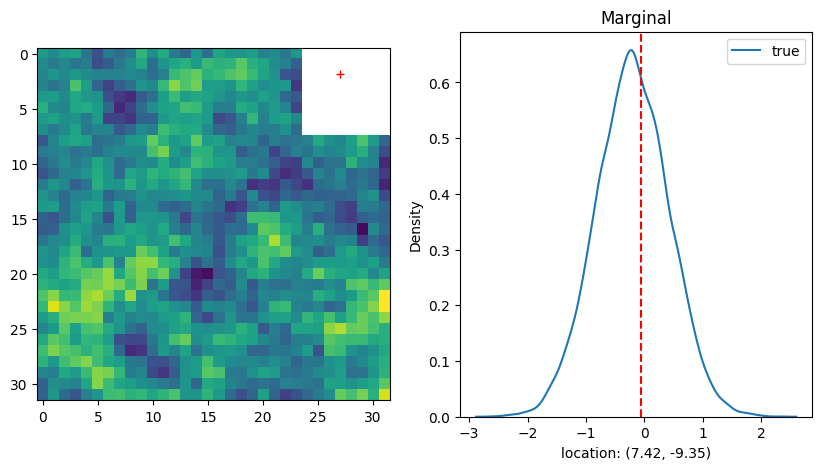

In [206]:
mask_type = "random_500"
number_of_replicates = 10000
folder_name = "visualizations/evaluation/ref_image1/true"
missing_index = np.random.randint(low = 0, high = m, size = 1)[0]
produce_marginal_density(mask, minX, maxX, minY, maxY, n, variance, lengthscale,
                         masked_vector, number_of_replicates, missing_index,
                         missing_indices, mask_type, folder_name, m, observed_vector)

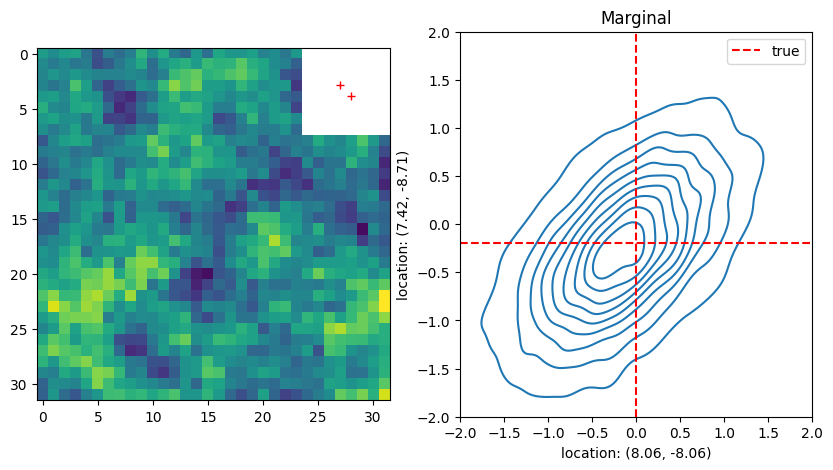

In [207]:
mask_type = "random_500"
number_of_replicates = 10000
folder_name = "visualizations/evaluation/ref_image1/true"
missing_two_indices = np.random.randint(low = 0, high = m, size = 2)
produce_bivariate_density(mask, minX, maxX, minY, maxY, n, variance, lengthscale,
                          masked_vector, number_of_replicates, missing_two_indices,
                          missing_indices, mask_type, folder_name, m, observed_vector)

In [ ]:
number_of_replicates = 20
conditional_fields = sample_conditional_distribution(mask, minX, maxX, minY, maxY, n,
                                                     variance, lengthscale, masked_vector,
                                                     number_of_replicates)
conditional_vector = observed_vector
min_value = -1.5
max_value = 1.5
figname = "visualizations/evaluation/multi_location_histograms/ref_image1/true/conditional_sample"
reffigname = "visualizations/evaluation/multi_location_histograms/ref_image1/true/ref_image.png"
visualize_spatial_field(observed_matrix.reshape((n,n)), min_value, max_value, reffigname)
for j in range(0, number_of_replicates):
    conditional_vector[missing_indices] = (conditional_fields[j,:]).reshape((m,1))
    conditional_matrix = vector_to_field(conditional_vector.reshape((n**2)), n)
    visualize_spatial_field(conditional_matrix, min_value, max_value,
                            (figname + "_" + str(j) + ".png"))